In [1]:
%load_ext autoreload
%autoreload 2

In [92]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits 
from astropy import coordinates, table
from astropy.visualization import make_lupton_rgb

from ekfplot import plot as ek
from ekfplot import colors as ec
from ekfstats import imstats

from carpenter import pixels, conventions
from pieridae.starbursts import sample

In [3]:
catalog, masks = sample.load_sample(filename='../../local_data/base_catalogs/mdr1_n708maglt26_and_pzgteq0p1.parquet')

/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/work/projects/merian/carpenter/src/carpenter/emission.py:338: RuntimeWarning: divide by zero encountered in reciprocal
  emission_correction = correct_NIISII(redshift_values, aperture_corrected_logmass)**-1


Computed aperture correction in 0.0 seconds.
Computed line contamination correction in 0.0 seconds.
Loading precomputed Galactic extinction map...
Interpolated Galactic extinction values from map.
Computed Galactic extinction correction in 0.7 seconds.
Computed internal extinction corrections in 0.7 seconds.


/Users/kadofong/work/projects/merian/agrias/python/agrias/photometry.py:115: RuntimeWarning: invalid value encountered in log10
  lsq_y = np.log10(np.array([ fdict[band] for band in plawbands ]))
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [138]:
targetid = 'M3241769297009196913'
target = conventions.produce_merianobjectname(*catalog.loc[targetid, ['RA','DEC']].values)
#target = 'J095618.67+030835.28'
#target = 'J101950.14+042441.99' # no substructure
#target = 'J100615.79+032656.01' # messy spiral
#target = 'J103511.49+030802.87' # no substructure, elongated body
#target = 'J093020.88+032019.66' # merging pair
#target = 'J121004.84+015540.11' # another stream
targetid = conventions.merianobjectname_to_catalogname(target, catalog)

In [139]:
dirname = '../local_data/test_cutout/'
bbmb = pixels.BBMBImage()
for band in ['g', 'n540', 'r', 'n708', 'i', 'z']:
    if band in ['n540', 'n708']:
        cutout = f'{dirname}/merian/{target}_{band.upper()}_merim.fits'
        psf = f'{dirname}/merian/{target}_{band.upper()}_merpsf.fits'
    else:
        cutout = f'{dirname}/hsc/{target}_HSC-{band}.fits'
        psf = f'{dirname}/hsc/{target}_HSC-{band}_psf.fits'
    
    if not os.path.exists(cutout) or not os.path.exists(psf):
        print(f"Missing files for {targetid} band {band}, skipping target...")
            
    bbmb.add_band(
        band,
        coordinates.SkyCoord(catalog.loc[targetid, 'RA'], catalog.loc[targetid, 'DEC'], unit='deg'),
        size=150,
        image=cutout,
        var=cutout,
        psf=psf,
        image_ext=1,
        var_ext=3,
        psf_ext=0
    )

In [140]:
_,sources = sep.extract( bbmb.image['i'].byteswap().newbyteorder(), 3, var=bbmb.var['i'].byteswap().newbyteorder(), segmentation_map=True)
central_source = sources[sources.shape[0]//2, sources.shape[1]//2]
sources = np.where(sources==central_source, 0, sources)

In [141]:
from scipy import ndimage

In [164]:
use_gen2 = True
wt = imstats.starlet_transform(bbmb.image['i'], gen2=use_gen2)
segmap_l = []
im_recon = []
for ix in range(0,len(wt)):
    err_samples = [
        np.std(abs(wt[ix])[:25,-25:]),
        np.std(abs(wt[ix])[-25:,-25:]),
        np.std(abs(wt[ix])[:25,:25]),
        np.std(abs(wt[ix])[-25,:25])
    ]
    
    _,segmap = sep.extract ( abs(wt[ix]), 10., err=np.median(err_samples), segmentation_map=True, deblend_cont=1.)
    sidx = segmap[segmap.shape[0]//2,segmap.shape[0]//2]
    #print(sidx)
    segmap_l.append(segmap)
    im_recon.append (np.where(segmap==sidx, wt[ix], 0.))
    #np.where((segmap==sidx)|((segmap>0)&(sources>0))
im_recon = imstats.inverse_starlet_transform(im_recon, gen2=use_gen2)
hf_image = bbmb.image['i'] - im_recon
hf_image = hf_image - ndimage.median_filter(hf_image, size=20)
hf_image = np.where(sources>0, 0, hf_image)

err_samples = [
    np.std(hf_image[:25,-25:]),
    np.std(hf_image[-25:,-25:]),
    np.std(hf_image[:25,:25]),
    np.std(hf_image[-25,:25])
]

_,lsb_features = sep.extract(hf_image, 1, err=np.median(err_samples), segmentation_map=True )
feature_cat,hsb_features = sep.extract(hf_image, 2, err=np.median(err_samples), segmentation_map=True )

features = np.zeros_like(hsb_features)
for ix in np.unique(lsb_features)[1:]:
    if (hsb_features[lsb_features==ix]>0).any():
        features[lsb_features==ix] = 1
features = ndimage.label(features)[0]
rmag = -2.5*np.log10(ndimage.sum_labels(bbmb.image['i'], features, np.unique(features)[1:])) + 27.
for ix in np.unique(features)[1:]:
    if rmag[ix-1] > 100.:
        features[features==ix] = 0

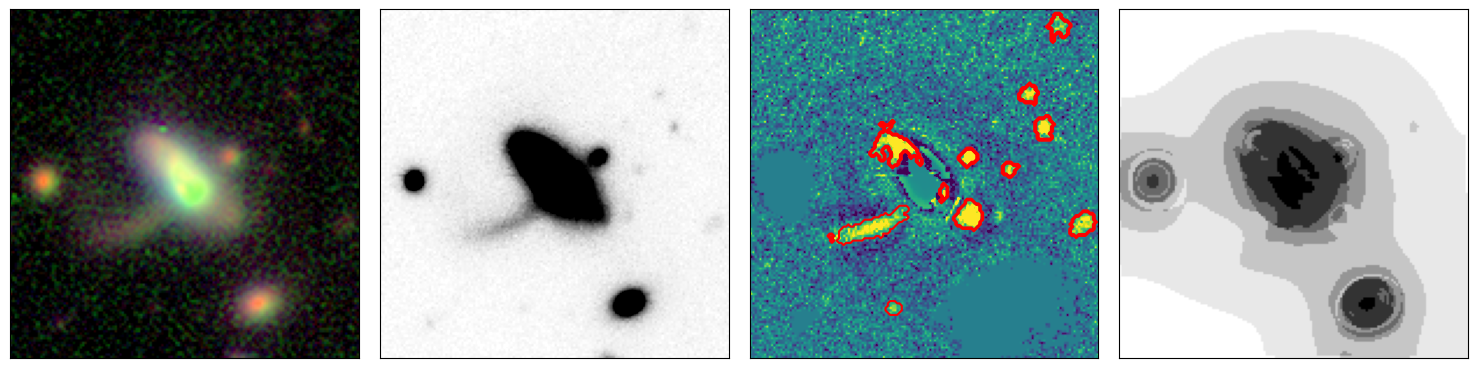

In [165]:
fig, axarr = plt.subplots(1,4,figsize=(15,4))
ek.imshow(hf_image, q=0.01,ax=axarr[2], cmap='viridis',)# qlow=sampling.get_quantile_of_value(hf_image.flatten(), 0.))
ek.contour(features,ax=axarr[2], colors='r')
ek.imshow(make_lupton_rgb(bbmb.image['i'],bbmb.image['n708'],bbmb.image['r'], stretch=1, Q=7), axarr[0])
ek.imshow(bbmb.image['i'], q=0.05,ax=axarr[1], cmap='Greys')
axarr[3].imshow(np.sum(np.array(segmap_l).astype(bool).astype(int),axis=0), origin='lower', cmap='Greys')

for ax in axarr:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout ()

In [83]:
row = catalog.loc['M3503743335489629017']
print(conventions.produce_merianobjectname(row.RA, row.DEC))


J121004.84+015540.11


In [103]:
from astropy.visualization import make_lupton_rgb

(<matplotlib.image.AxesImage at 0x3129d2c50>, <Axes: >)

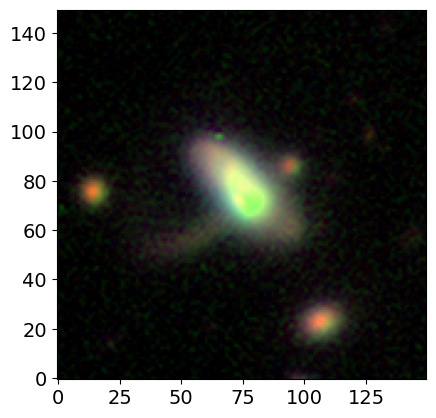

In [117]:
ek.imshow(
    make_lupton_rgb(bbmb.image['i'], bbmb.image['n708'], bbmb.image['r'], stretch=3, Q=5)
)